# Single impurity Anderson model with discrete bath


We calculate the Green function for a SIAM with a discrete bath

$$h = h_0 + h_{\rm int} + h_{\rm bath} + h_{\rm coup}$$

where

$$h_0 = -\mu \, (n_{\uparrow, 0} + n_{\uparrow, 0}) - h(n_{\uparrow,0} - n_{\downarrow,0})$$

$$h_{\rm int} = U n_{\uparrow, 0} n_{\downarrow, 0}$$

$$h_{\rm bath} = \sum_{i=1}^{N} \sum_{\sigma} E_i n_{\sigma,i}$$

and

$$h_{\rm coup} = \sum_{i=1}^{N} \sum_{\sigma} V_i (c^\dagger_{\sigma,i} c_{\sigma,0} + c^\dagger_{\sigma,0} c_{\sigma,i})$$

by solving with exact diagonalization. Then we can construct an impurity Green's function and self-energy, which can be continued using Nevanlinna. 

In [1]:
import sys, os
import numpy as np
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.atom_diag import *

from triqs.gf import *
from triqs.operators import c, c_dag, n, dagger
from itertools import product

# Get a list of all annihilation operators from a many-body operators
def get_fundamental_operators(op):
    idx_lst = []
    for term, val in op:
        for has_dagger, (bl, orb) in term:
            if not idx_lst.count([bl, orb]):
                idx_lst.append([bl,orb])
    return [c(bl, orb) for bl, orb in idx_lst]

### SIAM system parameters

In [2]:
beta = 40.             # Inverse temperature
mu = 1.             # Chemical potential
U = 2.              # On-site density-density interaction
E = [ 0.0, 2.0 ]    # Bath-site energies
V = [ 1.0, 2.5 ]    # Couplings to Bath-sites
n_orb = 1
n_orb_bath = len(E)

# triqs block structure
block_names = ['up', 'dn']
gf_struct = [ (s, n_orb) for s in block_names ]
# block structure of full Hamiltonian
gf_struct_tot = [[s, n_orb + n_orb_bath] for s in block_names]

# Green's function parameters
n_iw = int(20 * beta)
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
n_w = 1501
window = [-11,11]
w_mesh = MeshReFreq(window=window,n_w=n_w)
eta = 0.01

# ==== Local Hamiltonian ====
h_0 = - mu*( n('up',0) + n('dn',0) )
h_int = U * n('up',0) * n('dn',0)
h_imp = h_0 + h_int

# ==== Bath & Coupling Hamiltonian ====
h_bath, h_coup = 0, 0
for i, (E_i, V_i) in enumerate(zip(E, V)):
    for sig in ['up','dn']:
        h_bath += E_i * n(sig,n_orb + i)
        h_coup += V_i * (c_dag(sig,0) * c(sig,n_orb + i) + c_dag(sig,n_orb + i) * c(sig,0))

# ==== Total impurity hamiltonian ====
h_tot = h_imp + h_coup + h_bath

### Construct hybridization function and Weiss Field

In [3]:
Delta_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
Delta_iw << sum([V_i*V_i * inverse(iOmega_n - E_i) for V_i,E_i in zip(V, E)]);

# real frequency
Delta_w = BlockGf(mesh=w_mesh, gf_struct=gf_struct)
Delta_w << sum([V_i*V_i * inverse(Omega - E_i + 1j*eta) for V_i,E_i in zip(V, E)]);

# Weiss field
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
G0_iw['up'] << inverse(iOmega_n + mu - Delta_iw['up'])
G0_iw['dn'] << inverse(iOmega_n + mu- Delta_iw['dn'])

# real frequency
G0_w = BlockGf(mesh=w_mesh, gf_struct=gf_struct)
G0_w['up'] << inverse(Omega + mu - Delta_w['up'] + 1j*eta )
G0_w['dn'] << inverse(Omega + mu - Delta_w['dn'] + 1j*eta )

Greens Function G_dn with mesh Real Freq Mesh of size 1501, omega_min: -11, omega_max: 11 and target_shape (1, 1): 

### Construct the AtomDiag Object and solve it

In [4]:
# define fundamental operators
fop_imp  = [(s,o) for s, n in gf_struct for o in range(n)]
fop_bath = [(s,o) for s, o in product(block_names, range(n_orb, n_orb + n_orb_bath))]
fop_tot  = fop_imp + fop_bath

# ED object
ad_tot = AtomDiag(h_tot, fop_tot)

In [5]:
def _comm(A,B): return A*B - B*A
def _anticomm(A,B): return A*B + B*A

In [6]:
density_matrix = atomic_density_matrix(ad_tot, beta)

In [7]:
op_HF = -_anticomm(_comm(h_int, c('up',0)), c_dag('up',0))
S_HF = trace_rho_op(density_matrix, op_HF, ad_tot)
print(S_HF)

1.1874778391198606


###  Calculate and plot the single-particle Green function and self-energy

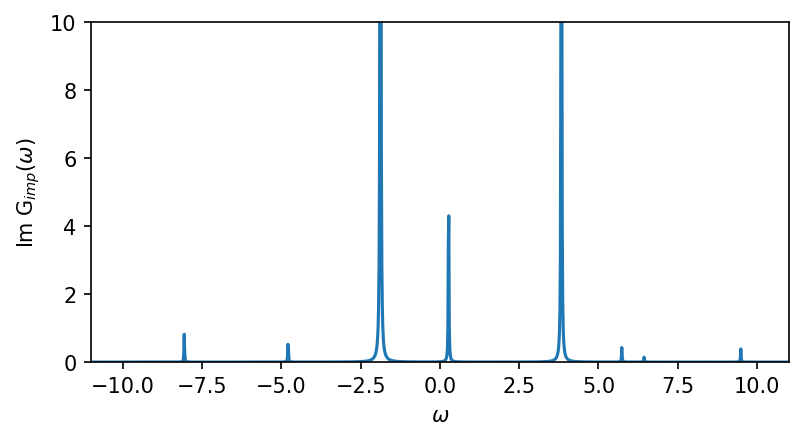

In [8]:
G_iw_tot = atomic_g_iw(ad_tot, beta, gf_struct_tot, n_iw)
block_list = [G_iw_tot[bl][:n_orb, :n_orb] for bl, n_orb in gf_struct]
G_iw = BlockGf(name_list=block_names, block_list=block_list)

# real frequency
G_w_tot = atomic_g_w(ad_tot, beta, gf_struct_tot, window,n_w, eta)
block_list = [G_w_tot[bl][:n_orb, :n_orb] for bl, n_orb in gf_struct]
G_w = BlockGf(name_list=block_names, block_list=block_list)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150, squeeze=False)
ax = ax.reshape(-1)

ax[0].oplot(-G_w['up'][0,0].imag)
ax[0].set_ylabel(r'Im G$_{imp} (\omega)$')
ax[0].set_ylim(0,10)
ax[0].set_xlim(window)
ax[0].get_legend().remove()

plt.show()

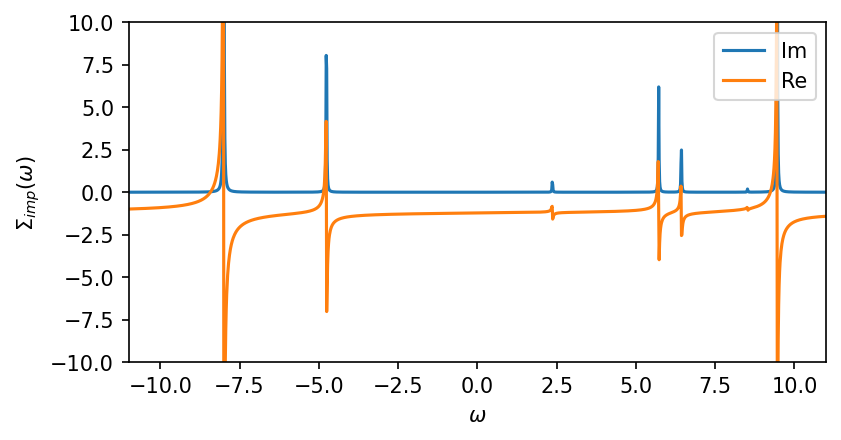

In [9]:
S_iw = G0_iw.copy()
S_iw << inverse(G0_iw) - inverse(G_iw)

S_w = G0_w.copy()
S_w << inverse(G0_w) - inverse(G_w)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150, squeeze=False)
ax = ax.reshape(-1)

ax[0].oplot(-S_w['up'][0,0].imag, label='Im')
ax[0].oplot(-S_w['up'][0,0].real, label='Re')
ax[0].set_ylabel(r'$\Sigma_{imp} (\omega)$')
ax[0].set_ylim(-10,10)
ax[0].set_xlim(window)

plt.show()

## Running the Nevanlinna analytic continuation

In [10]:
from triqs_Nevanlinna import Solver

first we setup the Nevanlinna solver for diagonal Green's functions (matrix values Green's functions can be continued using the "CARATHEODORY" kernel. See tutorial XYZ. Now we want to continue both the impurity Green's function and the self-energy from the Matsubara axis to the real frequency axis:

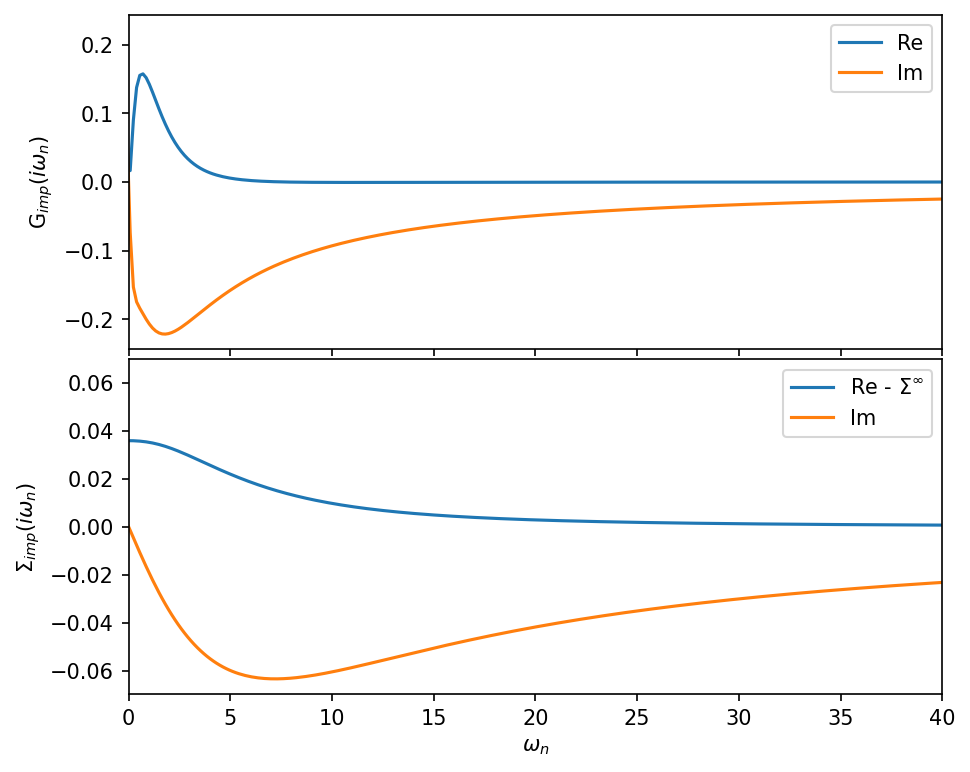

In [11]:
fig, ax = plt.subplots(2,1, figsize=(7,6), dpi=150, squeeze=False, sharex=True)
ax = ax.reshape(-1)
fig.subplots_adjust(hspace=0.03)

ax[0].oplot(G_iw['up'][0,0].real, label='Re')
ax[0].oplot(G_iw['up'][0,0].imag, label='Im')

ax[0].set_ylabel(r'G$_{imp} (i \omega_n)$')
ax[0].set_xlim(0,40)

ax[1].oplot(S_iw['up'][0,0].real-S_iw['up'][0,0].data[-1].real, label='Re - $\Sigma^\infty$')
ax[1].oplot(S_iw['up'][0,0].imag, label='Im')

ax[1].set_ylabel(r'$\Sigma_{imp} (i \omega_n)$')

plt.show()

In [12]:
# setup Nevanlinna kernel solver
solver = Solver(kernel="kernels::NEVANLINNA")

# solve 
solver.solve(G_iw['up'])

# evaluate on real frequency mesh
G_w_nvla = solver.evaluate(w_mesh, eta)

This is Nevanlinna analytical continuation. All off-diagonal elements will be ignored.


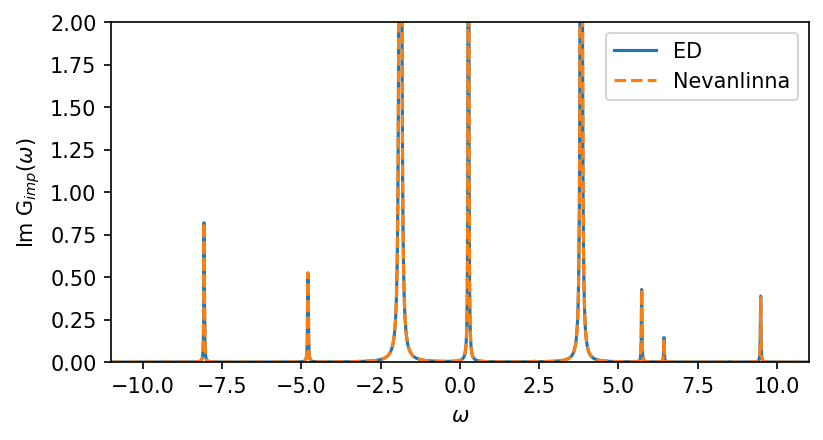

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150, squeeze=False)
ax = ax.reshape(-1)

ax[0].oplot(-G_w['up'][0,0].imag, label='ED')

ax[0].oplot(-G_w_nvla[0,0].imag,'--',label='Nevanlinna')

ax[0].set_ylabel(r'Im G$_{imp} (\omega)$')
ax[0].set_ylim(0,2)
ax[0].set_xlim(window)

plt.show()

### Continuing the self-energy

The self-energy can be continued without any prior treatment in the same as a Green's function:

In [14]:
# setup Nevanlinna kernel solver
solver = Solver(kernel="kernels::NEVANLINNA")

solver.solve(S_iw['up'])

S_w_nvla = solver.evaluate(w_mesh, eta)

This is Nevanlinna analytical continuation. All off-diagonal elements will be ignored.


In [15]:
# setup Nevanlinna kernel solver
solver_hf = Solver(kernel="kernels::NEVANLINNA")

solver_hf.solve(S_iw['up'] - S_HF)

S_w_nvla_const = solver_hf.evaluate(w_mesh, eta)

This is Nevanlinna analytical continuation. All off-diagonal elements will be ignored.


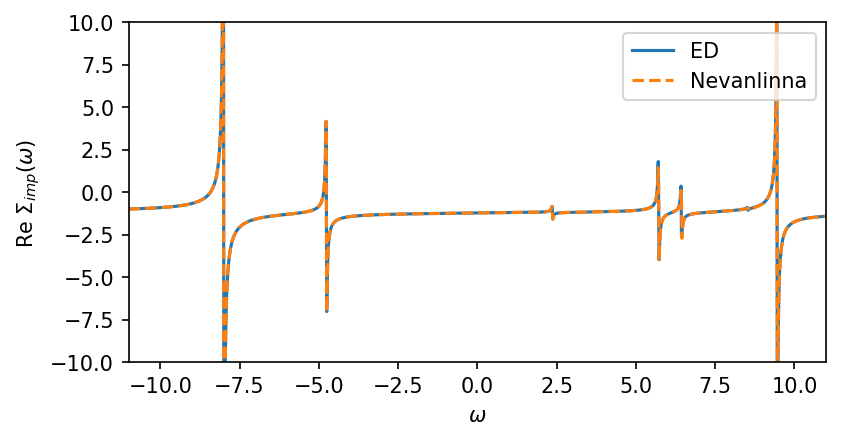

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150, squeeze=False)
ax = ax.reshape(-1)

ax[0].oplot(-S_w['up'][0,0].real, label='ED')

ax[0].oplot(-S_w_nvla[0,0].real,'--',label='Nevanlinna')

ax[0].set_ylabel(r'Re $\Sigma_{imp} (\omega)$')
ax[0].set_ylim(-10,10)
ax[0].set_xlim(window)

plt.show()

## Comparison to Pade & MaxEnt

In [17]:
from triqs_maxent import *

Starting serial run at: 2023-01-31 17:32:04.811680


### run Pade

In [18]:
G_w_pade = G0_w['up'].copy()
G_w_pade.set_from_pade(G_iw['up'], n_points=n_iw, freq_offset=eta)

### run MaxEnt

In [84]:
G_tau

Greens Function  with mesh Imaginary Time Mesh of size 4801, Domain: Matsubara domain with beta = 40, statistic = Fermion and target_shape (1, 1): 

In [107]:
G_tau = make_gf_from_fourier(G_iw['up'])
G_tau_noisy = G_tau.copy()
noise = 1e-5
G_tau_noisy.data[:,0,0] +=  np.random.normal(0.0,noise,(len(G_tau.mesh)))

In [108]:
tm = TauMaxEnt(cost_function='bryan', probability='normal')
tm.set_G_tau(G_tau_noisy)
tm.set_error(1.e-4)
tm.omega = LinearOmegaMesh(omega_min=window[0], omega_max=window[1], n_points=501)
result = tm.run()
print(('LineFit: ', result.analyzer_results['LineFitAnalyzer']['alpha_index']))

2023-01-31 18:02:14.972021
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 46.124011948521456
scaling alpha by a factor 4801 (number of data points)
alpha[ 0] =   9.60200000e+04, chi2 =   3.88433001e+04, n_iter=      39 
alpha[ 1] =   5.05079943e+04, chi2 =   1.97905836e+04, n_iter=      18 
alpha[ 2] =   2.65679805e+04, chi2 =   9.95189116e+03, n_iter=      18 
alpha[ 3] =   1.39751657e+04, chi2 =   4.87961646e+03, n_iter=      22 
alpha[ 4] =   7.35115173e+03, chi2 =   2.39092077e+03, n_iter=      24 
alpha[ 5] =   3.86681868e+03, chi2 =   1.23229743e+03, n_iter=      28 
alpha[ 6] =   2.03400600e+03, chi2 =   7.05204389e+02, n_iter=  

let's plot all results in comparison. The Nevanlinna, Pade, and MaxEnt results are each shifted by a small amount on the x-axis to visualize better the agreement in the first plot:

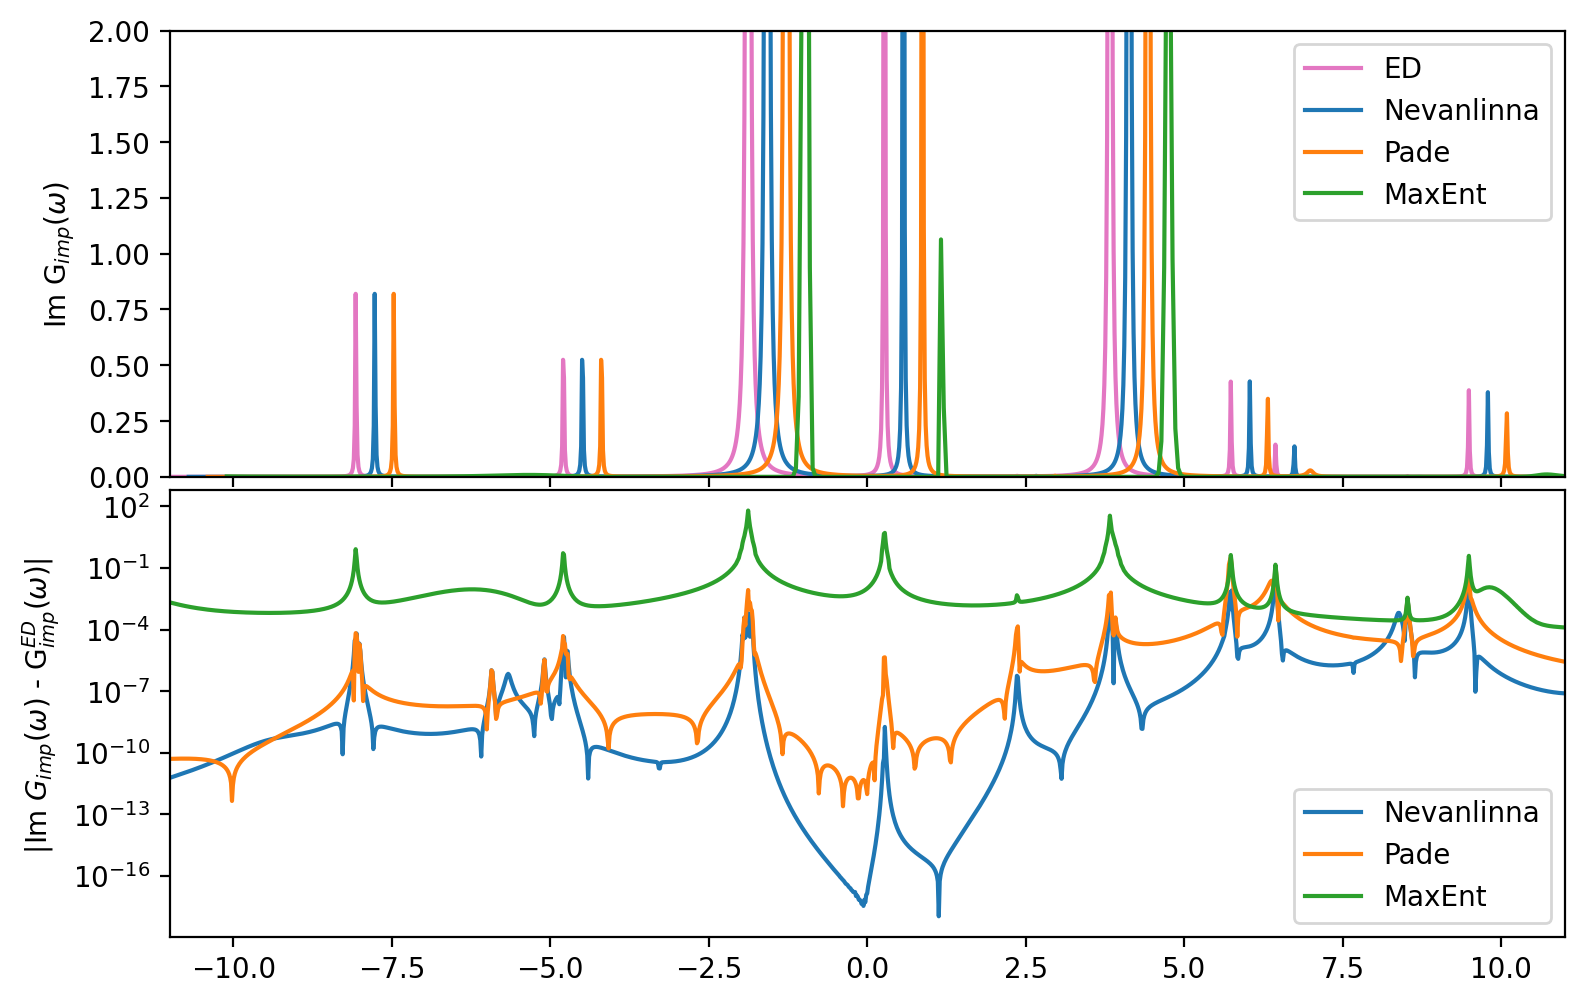

In [109]:
fig, ax = plt.subplots(2,1, figsize=(9,6), dpi=200, squeeze=False, sharex=True)
ax = ax.reshape(-1)
fig.subplots_adjust(hspace=0.03)

w_mesh_arr = np.linspace(w_mesh.omega_min, w_mesh.omega_max, len(w_mesh))

G_w_maxent = np.interp(w_mesh_arr, np.array(result.omega), result.analyzer_results['BryanAnalyzer']['A_out'])

ax[0].plot(w_mesh_arr, -G_w['up'][0,0].data.imag, color='C6', label='ED')

ax[0].plot(w_mesh_arr+0.3, -G_w_nvla[0,0].data.imag,label='Nevanlinna')

ax[0].plot(w_mesh_arr+0.6, -G_w_pade[0,0].data.imag,label='Pade')

ax[0].plot(w_mesh_arr+0.9, G_w_maxent, label='MaxEnt')

ax[0].set_ylabel(r'Im G$_{imp} (\omega)$')
ax[0].set_ylim(0,2)
ax[0].legend()

ax[1].semilogy(w_mesh_arr, np.abs(G_w['up'][0,0].data.imag - G_w_nvla[0,0].data.imag), label='Nevanlinna')

ax[1].semilogy(w_mesh_arr, np.abs(G_w['up'][0,0].data.imag - G_w_pade[0,0].data.imag), label='Pade')

ax[1].semilogy(w_mesh_arr, np.abs(G_w['up'][0,0].data.imag - G_w_maxent), label='MaxEnt')

ax[1].set_ylabel(r'  |Im $ G_{imp} (\omega)$ - G$_{imp}^{ED} (\omega) |$')
ax[1].set_xlim(window)
ax[1].legend()

plt.show()

## self-energy comparison 

In [21]:
S_w_pade = G0_w['up'].copy()
S_w_pade.set_from_pade(S_iw['up'], n_points=n_iw, freq_offset=eta)

In [22]:
S_w_pade_const = G0_w['up'].copy()
S_w_pade_const.set_from_pade(S_iw['up']- S_HF, n_points=n_iw, freq_offset=eta)

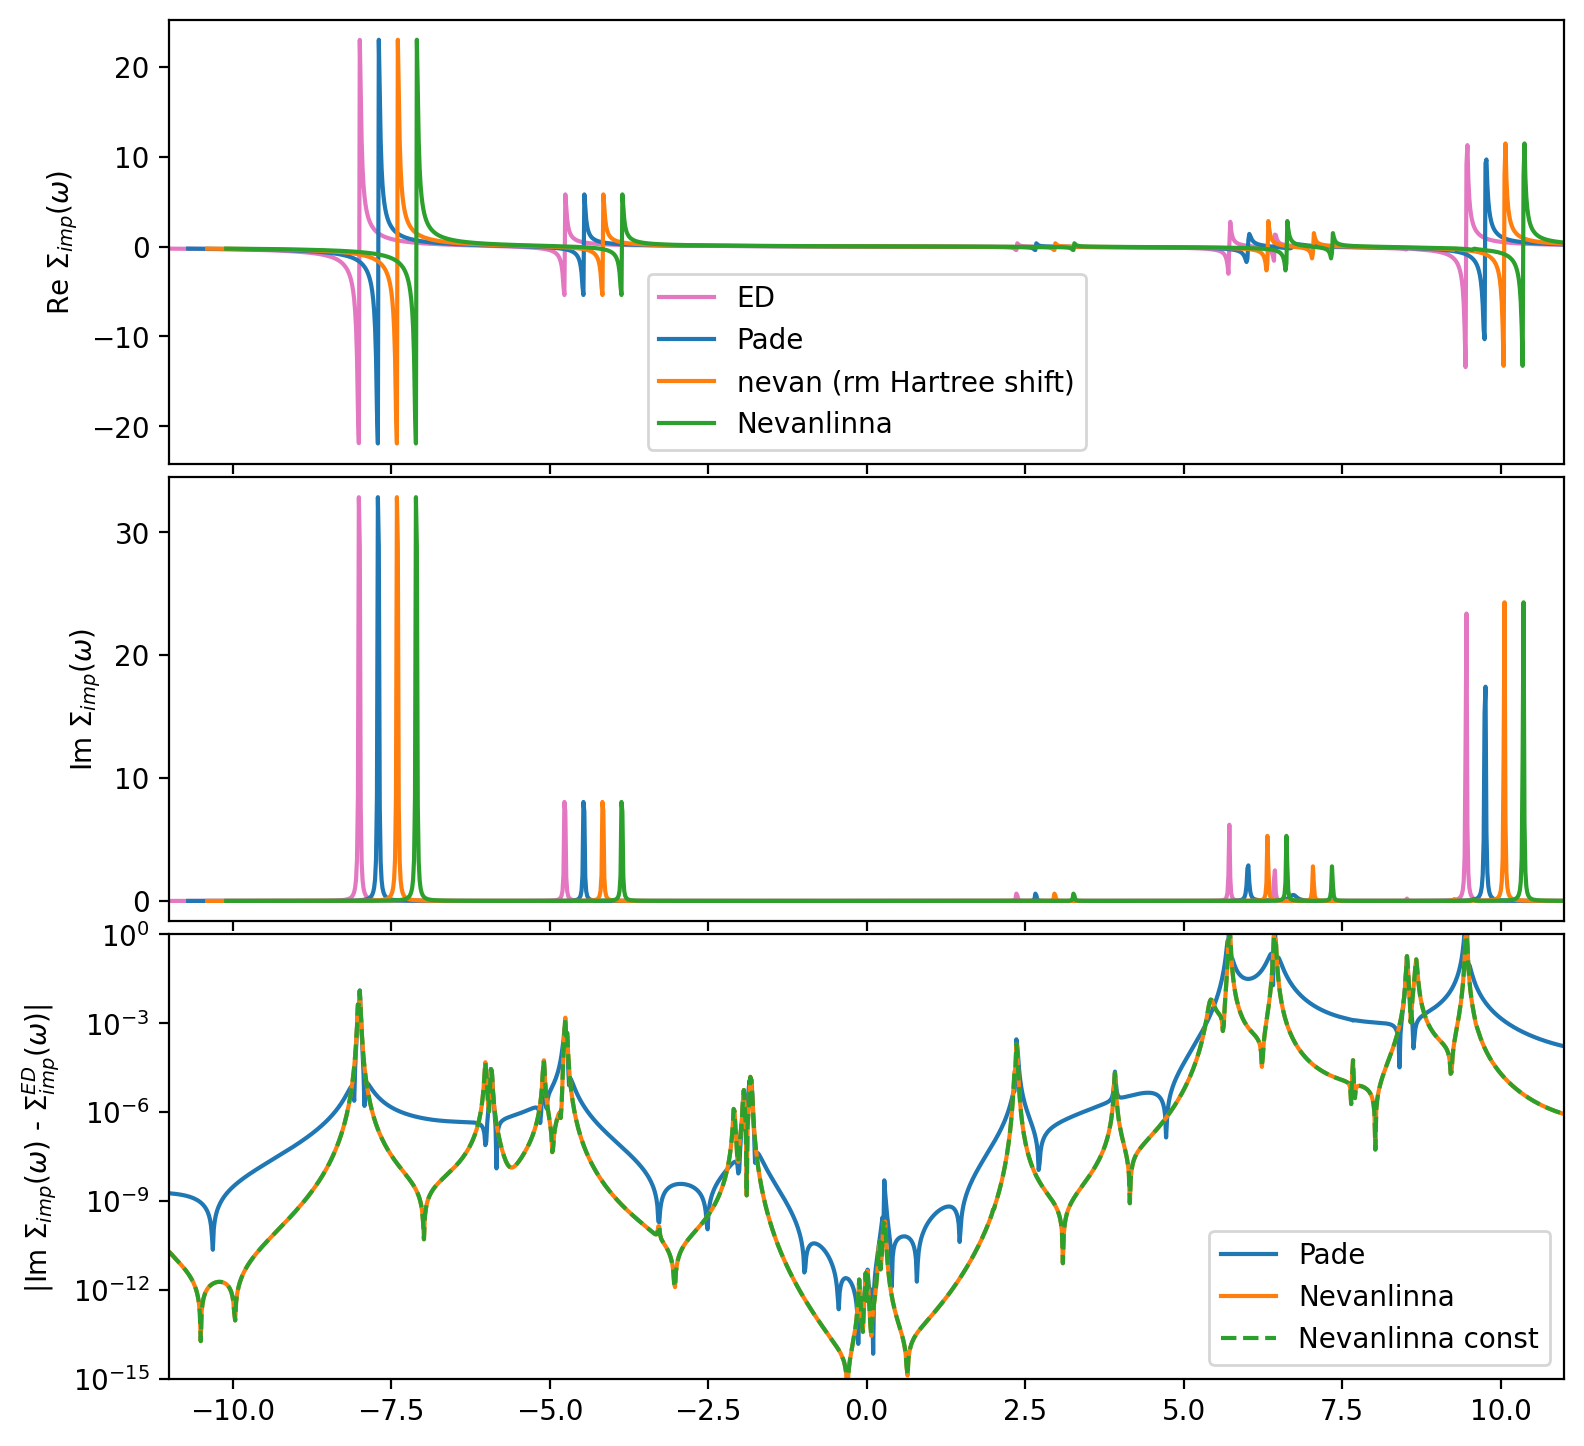

In [28]:
fig, ax = plt.subplots(3,1, figsize=(9,9), dpi=200, squeeze=False, sharex=True)
ax = ax.reshape(-1)
fig.subplots_adjust(hspace=0.03)

w_mesh_arr = np.linspace(w_mesh.omega_min, w_mesh.omega_max, len(w_mesh))


ax[0].plot(w_mesh_arr, S_w['up'][0,0].data.real - S_w['up'][0,0](0.0).real, color='C6', label='ED')

ax[0].plot(w_mesh_arr+0.3, S_w_pade[0,0].data.real - S_w_pade[0,0](0.0).real,label='Pade')

# ax[0].plot(w_mesh_arr+0.6, S_w_pade_const[0,0].data.real - S_w_pade_const[0,0](0.0).real,label='Pade (rm Hartree shift)')

ax[0].plot(w_mesh_arr+0.6, S_w_nvla_const[0,0].data.real - S_w_nvla_const[0,0](0.0).real,label='nevan (rm Hartree shift)')



ax[0].plot(w_mesh_arr+0.9, S_w_nvla[0,0].data.real - S_w_nvla[0,0](0.0).real,label='Nevanlinna')



ax[0].set_ylabel(r'Re $\Sigma_{imp} (\omega)$')
ax[0].legend()


ax[1].plot(w_mesh_arr, -S_w['up'][0,0].data.imag, color='C6', label='ED')

ax[1].plot(w_mesh_arr+0.3, -S_w_pade[0,0].data.imag,label='Pade')

ax[1].plot(w_mesh_arr+0.6, -S_w_nvla_const[0,0].data.imag,label='Nevanlinna (rm Hartree shift)')

ax[1].plot(w_mesh_arr+0.9, -S_w_nvla[0,0].data.imag,label='Nevanlinna')


ax[1].set_ylabel(r'Im $\Sigma_{imp} (\omega)$')
ax[1].set_xlim(window)
# ax[1].legend()


ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_pade[0,0].data.imag), label='Pade')

# ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_pade_const[0,0].data.imag), label='Pade (rm Hartree)')

ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_nvla[0,0].data.imag), label='Nevanlinna')

ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_nvla_const[0,0].data.imag), '--', label='Nevanlinna const')

ax[2].set_ylabel(r'  |Im $ \Sigma_{imp} (\omega)$ - $\Sigma_{imp}^{ED} (\omega) |$')
ax[2].set_xlim(window)
ax[2].set_ylim(1e-15,1e-0)
ax[2].legend()

plt.show()

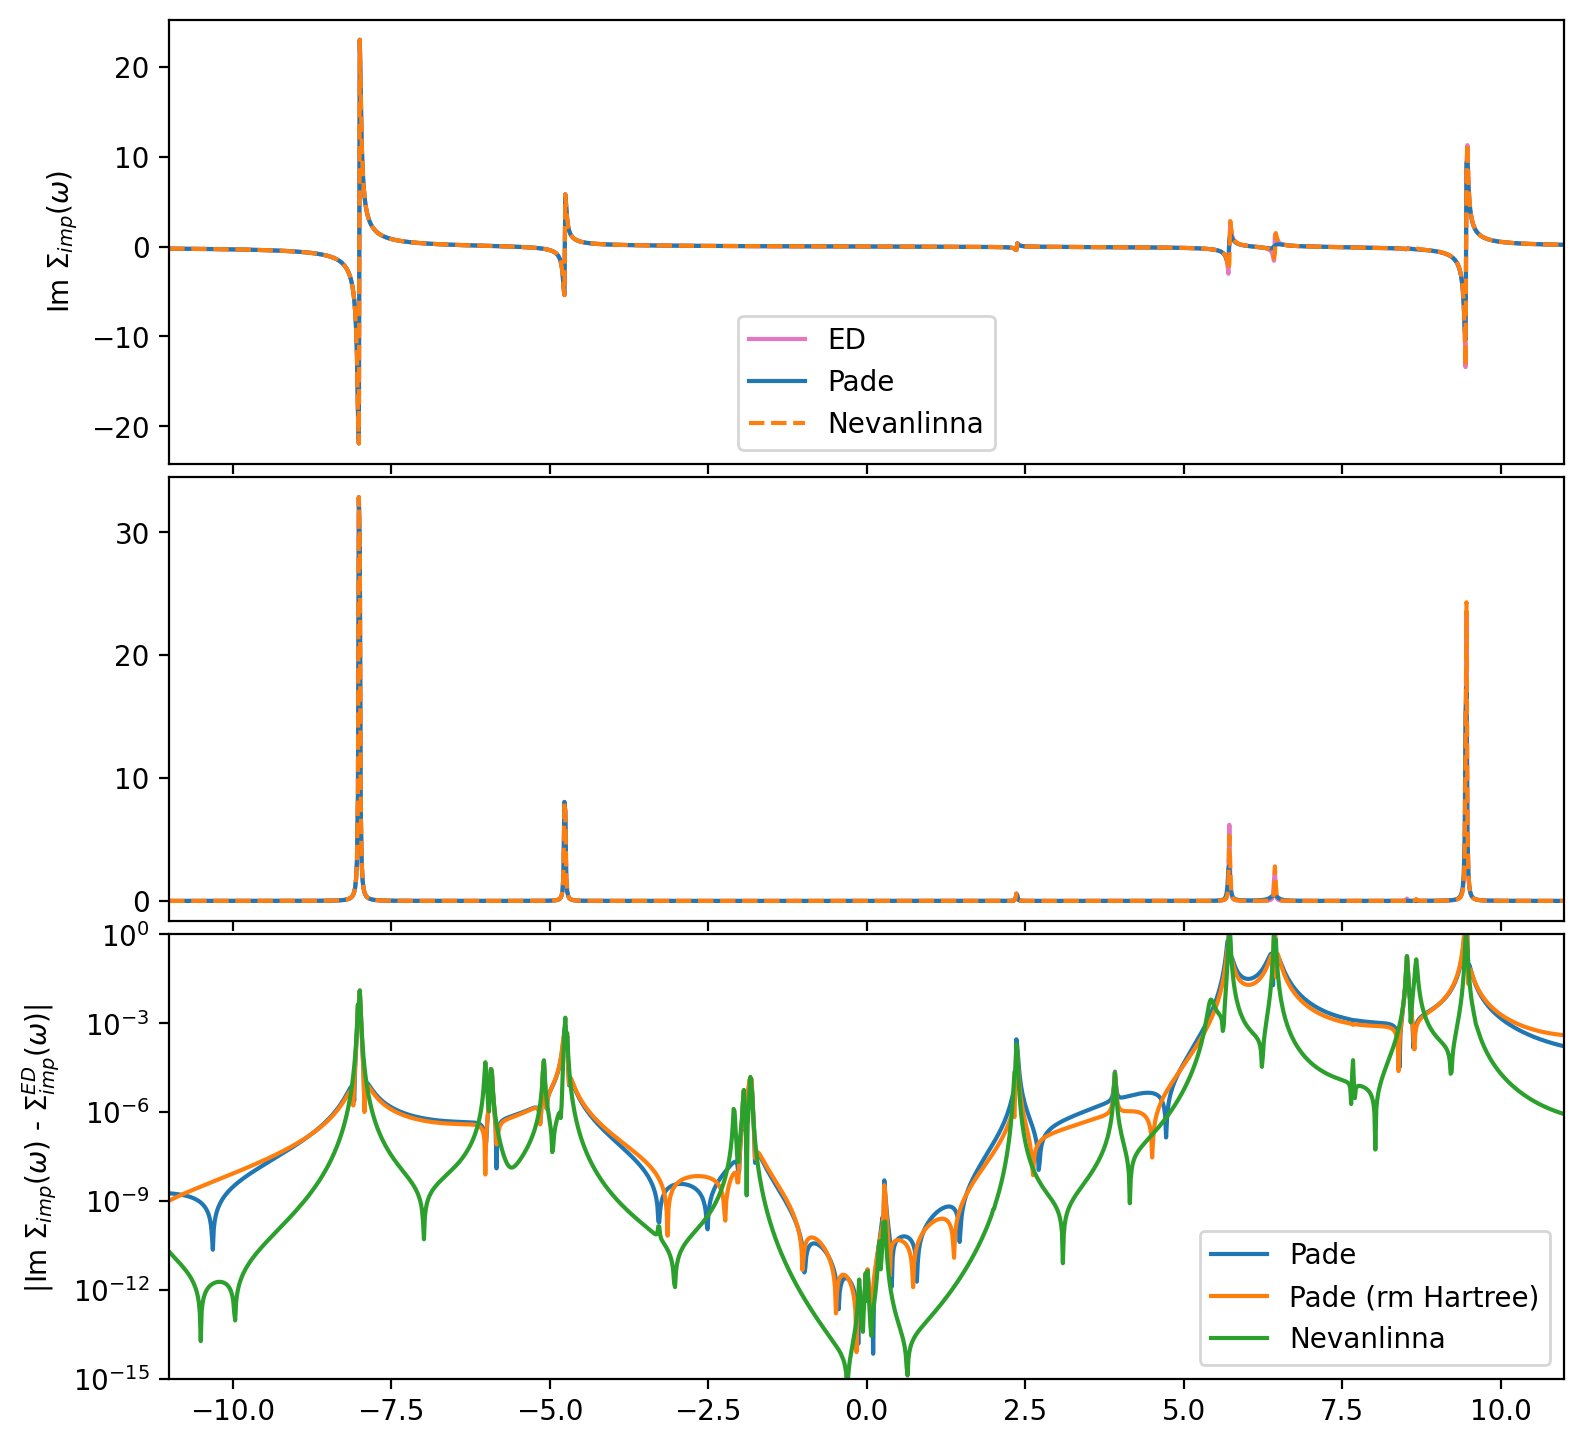

In [27]:
fig, ax = plt.subplots(3,1, figsize=(9,9), dpi=200, squeeze=False, sharex=True)
ax = ax.reshape(-1)
fig.subplots_adjust(hspace=0.03)

w_mesh_arr = np.linspace(w_mesh.omega_min, w_mesh.omega_max, len(w_mesh))


ax[0].plot(w_mesh_arr, S_w['up'][0,0].data.real - S_w['up'][0,0](0.0).real, color='C6', label='ED')

ax[0].plot(w_mesh_arr, S_w_pade[0,0].data.real - S_w_pade[0,0](0.0).real,label='Pade')

# ax[0].plot(w_mesh_arr, S_w_pade_const[0,0].data.real - S_w_pade_const[0,0](0.0).real,label='Pade (rm Hartree shift)')

ax[0].plot(w_mesh_arr, S_w_nvla[0,0].data.real - S_w_nvla[0,0](0.0).real, '--',label='Nevanlinna')



ax[0].set_ylabel(r'Re $\Sigma_{imp} (\omega)$')
ax[0].legend()


ax[1].plot(w_mesh_arr, -S_w['up'][0,0].data.imag, color='C6', label='ED')

ax[1].plot(w_mesh_arr, -S_w_pade[0,0].data.imag,label='Pade')

# ax[1].plot(w_mesh_arr, -S_w_pade_const[0,0].data.imag,label='Pade (rm Hartree shift)')

ax[1].plot(w_mesh_arr, -S_w_nvla[0,0].data.imag, '--',label='Nevanlinna')


ax[0].set_ylabel(r'Im $\Sigma_{imp} (\omega)$')
ax[1].set_xlim(window)
# ax[1].legend()


ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_pade[0,0].data.imag), label='Pade')

ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_pade_const[0,0].data.imag), label='Pade (rm Hartree)')

ax[2].semilogy(w_mesh_arr, np.abs(S_w['up'][0,0].data.imag - S_w_nvla[0,0].data.imag), label='Nevanlinna')

ax[2].set_ylabel(r'  |Im $ \Sigma_{imp} (\omega)$ - $\Sigma_{imp}^{ED} (\omega) |$')
ax[2].set_xlim(window)
ax[2].set_ylim(1e-15,1e-0)
ax[2].legend()

plt.show()